# Toy Model: 

$$\nabla\,\mathsf{T} = \mathrm{C}\,\mathsf{T} + \mathsf{F}$$ 

where,

$\mathsf{T} = 
\begin{bmatrix}
    \mathsf{T_O} \\
    \mathsf{T_A} 
\end{bmatrix}$ is the vector containing sub-component temperatures,

$\mathsf{F} = 
\begin{bmatrix}
    \emptyset \\
    \mathsf{F}(t) 
\end{bmatrix}$ is the forcing function, usually assumed to be stochastic white noise for the atmospheric component. The diagonal operator $\nabla$ encodes the time-dependent factorisation of the constituent ODEs such that,

$$\nabla = 
\begin{bmatrix}
    \mathsf{m}\displaystyle\frac{\mathsf{d}}{\mathsf{d}t} & \emptyset \\
    \emptyset & \displaystyle\frac{\mathsf{d}}{\mathsf{d}t} 
\end{bmatrix},$$ 

where $\mathsf{m}$ encodes the relative temporal scale, and lastly

$$\mathrm{C} = 
\begin{bmatrix}
    \mathrm{C}_\mathsf{OO} & \mathrm{C}_\mathsf{OA} \\
    \mathrm{C}_\mathsf{AO} & \mathrm{C}_\mathsf{AA} 
\end{bmatrix}$$

is the covariance matrix. The system of equations may be written in coupled form as

$$\displaystyle\mathsf{m}\frac{\mathsf{dT_O}}{\mathsf{d}t} = \mathrm{C}_\mathsf{OO}\mathsf{T_O} + \mathrm{C}_\mathsf{OA}\mathsf{T_A},$$

$$\displaystyle\frac{\mathsf{dT_A}}{\mathsf{d}t} = \mathrm{C}_\mathsf{AO}\mathsf{T_O} + \mathrm{C}_\mathsf{AA}\mathsf{T_A} + \mathsf{F}(t).$$

In the absence of stochastic forcing. i.e. $\mathsf{F}(t) = \emptyset$, the system of coupled ODEs are easily solved using <font color='blue'>scipy.integrate.odeint()</font> to yield the time-series and the auto- and cross-correlations.


In [1]:
# environment
import matplotlib.font_manager as fm
import numpy as np
import random as rand
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib.pyplot import gca
import os 
%matplotlib inline

cwd = os.getcwd()
pwd = os.path.abspath(os.path.join(cwd, os.pardir))
fontloc = pwd + '/Fonts/SFMono-Regular.otf'
font = fm.FontProperties(fname = fontloc)
prop = fm.FontProperties(fname = fontloc,size = 8)

#ticks font
def ticks(ax):
    for label in ax.get_xticklabels():
        label.set_fontproperties(font)
    for label in ax.get_yticklabels():
        label.set_fontproperties(font)

In [2]:
# model parameters, variables and functions
rescale = 1.0           #rescaling to reproduce Liu15 results

Coo = -1.08 * rescale
Coa = 1.0 * rescale
Cao = 0.1 * rescale
Caa = -1.12 * rescale
m = 10.0
Toi = 0.1
Tai = 0.1

# time series
t_start = 0.0
t_end = 300.0
time_samples = 10000

def autocorr(x,t):
    result = np.correlate(x, x, mode='same')
    lag_time = np.linspace(start = -t.max()/2, stop = t.max()/2, num = time_samples)
    return [lag_time, result]

def crosscorr(x,y,t):
    result = np.correlate(x, y, mode='same')
    lag_time = np.linspace(start = -t.max()/2, stop = t.max()/2, num = time_samples)
    return [lag_time, result]

def f(x,t):
    To = x[0]
    Ta = x[1]
    f0 = (1/m)*(Coo*To + Coa*Ta)
    f1 = Cao*To + Caa*Ta
    return [f0,f1]

t = np.linspace(start=t_start,stop=t_end,num=time_samples)

In [3]:
# solve ODEs
x0 = [Toi,Tai]
soln = odeint(f,x0,t)
To = soln[:,0]
Ta = soln[:,1]

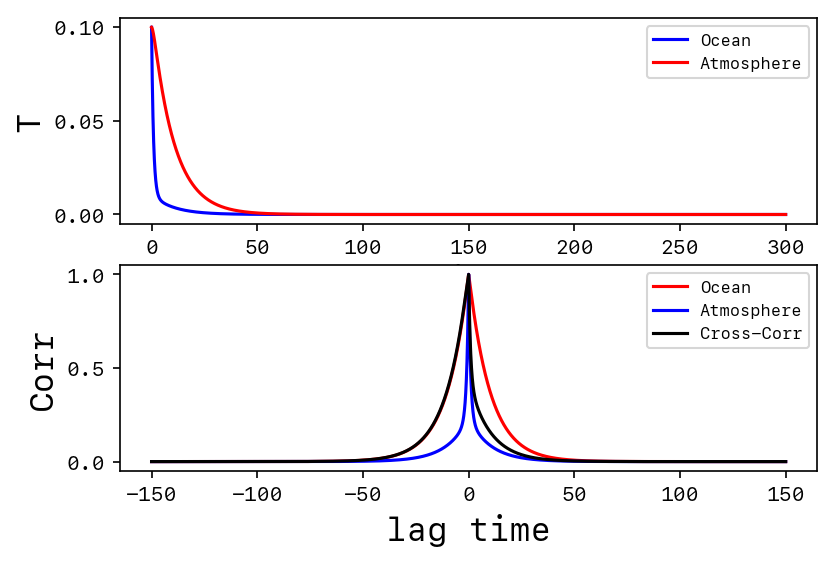

In [4]:
#plot results
plt.figure(dpi=150)
plt.subplot(2, 1, 1)
plt.xlabel('time',fontproperties=font,fontsize=16)
plt.ylabel('T',fontproperties=font,fontsize=16)
plt.plot(t,Ta,'b',t,To,'r')
ax = gca(); ticks(ax)
plt.gca().legend(('Ocean','Atmosphere'),prop=prop);

[lag_time_To, autocorr_To] = autocorr(To,t)
[lag_time_Ta, autocorr_Ta] = autocorr(Ta,t)
[lag_time_T, crosscorr_T] = crosscorr(Ta,To,t)

plt.subplot(2, 1, 2)
plt.plot(lag_time_To,autocorr_To/float(autocorr_To.max()),'r',lag_time_Ta,autocorr_Ta/float(autocorr_Ta.max()),'b',lag_time_T,crosscorr_T/float(crosscorr_T.max()),'k')
plt.xlabel('lag time',fontproperties=font,fontsize=16)
plt.ylabel('Corr',fontproperties=font,fontsize=16)
ax = gca(); ticks(ax)
plt.gca().legend(('Ocean','Atmosphere','Cross-Corr'),prop=prop);

In the presence of the stochastic forcing term(s), one must find alternative ways to solve the coupled ODEs as <font color='red'>scipy.integrate.odeint()</font> wouldn't work in this case. We use <font color='blue'>sdeint()</font> in this case.

In [5]:
import sdeint

# define forcing function (weiner process with cross-section 1.0)
crosssec = 0.5 * rescale             #crosssection of white noise
W = np.diag([0.0,crosssec])

# redefine unforced part
C = np.array([[(1/m)*Coo, (1/m)*Coa],
              [Cao, Caa]])

def unforc(x, t):
    return C.dot(x)

def forc(x, t):
    return W

soln = sdeint.itoint(unforc,forc,x0,t)
To = soln[:,0]
Ta = soln[:,1]

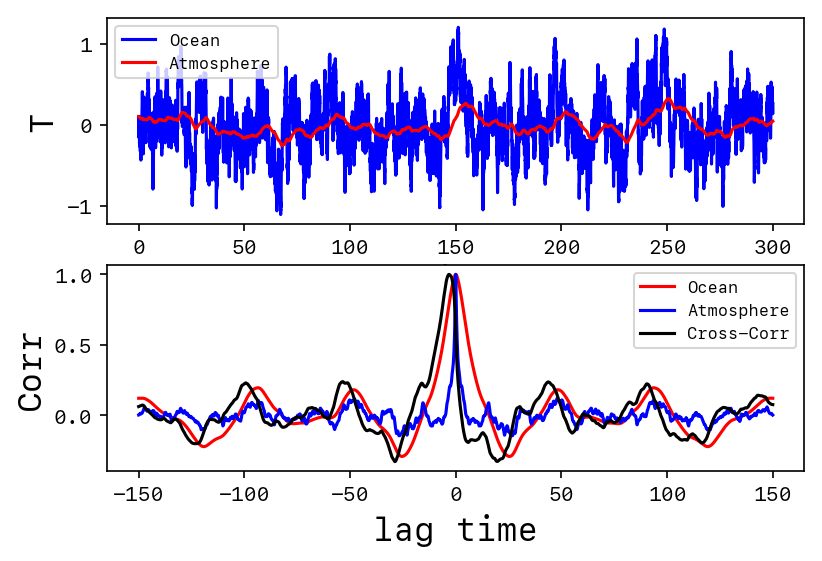

In [6]:
#plot results
plt.figure(dpi=150)
plt.subplot(2, 1, 1)
plt.xlabel('time',fontproperties=font,fontsize=16)
plt.ylabel('T',fontproperties=font,fontsize=16)
plt.plot(t,Ta,'b',t,To,'r')
ax = gca(); ticks(ax)
plt.gca().legend(('Ocean','Atmosphere'),prop=prop);

[lag_time_To, autocorr_To] = autocorr(To,t)
[lag_time_Ta, autocorr_Ta] = autocorr(Ta,t)
[lag_time_T, crosscorr_T] = crosscorr(Ta,To,t)

plt.subplot(2, 1, 2)
plt.plot(lag_time_To,autocorr_To/float(autocorr_To.max()),'r',lag_time_Ta,autocorr_Ta/float(autocorr_Ta.max()),'b',lag_time_T,crosscorr_T/float(crosscorr_T.max()),'k')
plt.xlabel('lag time',fontproperties=font,fontsize=16)
plt.ylabel('Corr',fontproperties=font,fontsize=16)
ax = gca(); ticks(ax)
plt.gca().legend(('Ocean','Atmosphere','Cross-Corr'),prop=prop);

We find that the results of Liu15 are reproduced when all model parameters are rescales by a factor of roughly 0.1.